## Calculating Walking distance in Python. NetworkX vs Pandana.
There is no need for GPU when Pandana is at least 1000 times faster.   
Blog post from: https://lenkahas.com/post/pandana.html


### 1. Introduction
Let's say you have spatial point data and you want to calculate walking distances between all combination of the points.   
For example, you have data of local bars and you want to find out all the walking distances between them, so you can include them in your regression model (or anything else), for example as a variable that defines how accessible two pubs are to each other.

This post will show you how you can do that in python using:
1. osmnx package to generate OSM road network
2. networkx package to find the nearest point on that network and calulate the walking distance between them
3. pandana package to make this significantly faster!

**Data**   
Availiable here: https://github.com/lenkahas/sample_data/blob/main/points.geojson

**Background**   
You might need some essential information that will help you to understand what we are doing here. Feel free to skip this part and go straight to the code.

What is the walking distance?   
It's exactly what it says. Walking distance from one place to another. In other words, how far is the place from where I stand along the walking path. This information is crucial for estimating how long is it going to take me to go there, how much effort or money will this cost me. Those are all variables that contribute to estimations of accessibility, connectivity, mobility or others.

For more detailed description, check out the original tutorial.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox # install osmnx first, it will download appropriate version of networkx
import networkx as nx
from pyproj import CRS
import itertools

import pandana
print(pandana.__version__)

0.7


## 2. Load and inspect the data

In [2]:
# define coordinates if you need them
wgs84 = CRS(4326)
bng = CRS(27700)
print(wgs84)

EPSG:4326


Load the point data and create flows

In [3]:
pois = gpd.read_file("./points.geojson")
# pois.crs # check the CRS

In [4]:
pois.head()

,ID_code,X,Y,geometry
0,A91120,-2.559063,51.502830,POINT (-2.55906 51.50283)
1,A99931,-2.596140,51.459182,POINT (-2.59614 51.45918)
2,A99986,-2.538833,51.483143,POINT (-2.53883 51.48314)
3,L81002,-2.930352,51.360207,POINT (-2.93035 51.36021)
4,L81004,-2.767317,51.482805,POINT (-2.76732 51.48281)


## 3. Create Origin-Destination pairs

In [5]:
# take first 5 points and find all possible combinations
pois = pois.iloc[0:6,:]

# create a list of all the ID's
p_li = list(pois['ID_code'].unique())

# get all unique combinations of all the origins and destinations
flows = pd.DataFrame(list(itertools.product(p_li,p_li))).rename(columns = {0:'origin',1:'destination'})

flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   origin       36 non-null     object
 1   destination  36 non-null     object
dtypes: object(2)
memory usage: 708.0+ bytes


By taking the product of the 6 points, we get $6x6=36$ unique combinations of origins and destinations.

## 4. Use NetworkX to calculate walking distances
### 4.1 Load Graph
The ``osmnx`` package has very useful function `graph_from_bbox` which loads the osm roads graph quite quickly.   
Here I am loading walking paths for whola area of Avon where my points are located, which is quite a big area so expect this to take few minutes.

In [6]:
# create bounding box for our data 
bbox = [51.623985, 51.291124,  -2.272797, -3.029480] 

# generate graph based on the bounding box from the Avon area
avon = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], 
                               retain_all=False, 
                               truncate_by_edge=True, 
                               simplify=False,
                               network_type='walk')

In [7]:
# get the nodes and the edges into geopandas
nodes, edges = ox.graph_to_gdfs(avon, nodes=True, edges=True)

### 4.2 Find nearest points
Using [`osmnx.distance.nearest_nodes(G, X, Y, return_dist=False)`](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes) to find the nearest node to each point.   
Def: Find the nearest node to a point or to each of several points.    
If X and Y are single coordinate values, this will return the nearest node to that point. If X and Y are lists of coordinate values, this will return the nearest node to each point.


In [8]:
# define function for the nearest neighbour
def nearest_node(a,b):
    nearest_node,dist=ox.nearest_nodes(avon, pois["X"], pois["Y"], return_dist=True)
    return nearest_node

In [9]:
# find the nearest node to each point
pois['NX_node'] = nearest_node(pois['Y'],pois['X'])
np.vectorize(pois['NX_node'])
pois.head()

,ID_code,X,Y,geometry,NX_node
0,A91120,-2.559063,51.502830,POINT (-2.55906 51.50283),2914306154
1,A99931,-2.596140,51.459182,POINT (-2.59614 51.45918),1572010429
2,A99986,-2.538833,51.483143,POINT (-2.53883 51.48314),2094196650
3,L81002,-2.930352,51.360207,POINT (-2.93035 51.36021),317399984
4,L81004,-2.767317,51.482805,POINT (-2.76732 51.48281),298172819


Create list of the node id's and check if they exist and if they are on the right place.

In [10]:
nodelist = list(pois['NX_node'].unique())
nodes[nodes.index.isin(nodelist)]

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
298172819,51.482619,-2.767715,3,NaN,NaN,POINT (-2.76772 51.48262)
317399984,51.360247,-2.930562,2,NaN,NaN,POINT (-2.93056 51.36025)
1572010429,51.459374,-2.596515,1,NaN,NaN,POINT (-2.59651 51.45937)
2094196650,51.482695,-2.538694,2,NaN,NaN,POINT (-2.53869 51.48270)
2424544783,51.413636,-2.571634,3,NaN,NaN,POINT (-2.57163 51.41364)
2914306154,51.502744,-2.558880,1,NaN,NaN,POINT (-2.55888 51.50274)


(own interpretation) In the next step, we aim to enhance the `flows` table by including information about both the origins and destinations of the flows. Specifically, we want to append geographical and possibly other descriptive data from the `pois` (Points of Interest) table to our flows data. Here's how the process works:

1. **Dropping the 'geometry' column**: The `.loc[:, pois.columns != 'geometry']` syntax is used to select all columns except the 'geometry' column from the `pois` table. This is because we are presumably interested in non-spatial attributes (like XY coordinates) from the `pois` table to merge with our `flows` table.

2. **Performing a left join**: We then perform two left joins using the `merge` function. The first merge adds data from `pois` to `flows` based on the `origin` column in `flows` and the `ID_code` column in `pois`. The second merge adds data based on the `destination` column in `flows`. A left join is used here to ensure all rows from the `flows` table are retained in the result, even if there is no matching `ID_code` in `pois`. This approach ensures we don't lose any flow data even if the corresponding point of interest is missing.

3. **Renaming columns for clarity**: After merging, columns related to origins and destinations would have overlapping names (e.g., `X`, `Y`, `ID_code`), making it difficult to distinguish between the origin and destination data. Thus, we rename these columns to include a suffix (`_o` for origin and `_d` for destination), making the dataset clearer and easier to understand.

4. **Displaying the header**: Finally, `flows_full.head()` displays the first few rows of the newly created table, allowing us to verify that the merge and renaming operations were successful.

In summary, this step enriches the `flows` data with detailed information about both the origins and destinations by merging it with the `pois` table, ensuring that we maintain a clear distinction between data related to origins and destinations.


In [11]:
# get the node id's to flow data
# create two seperate data the target origins and target destinations with the XY coordinates
flows_full = flows.merge(pois.loc[:, pois.columns != 'geometry'], left_on = 'origin', right_on = 'ID_code', how = 'left')

# lets just rename everything for the sake of clarity
flows_full = flows_full.merge(pois.loc[:, pois.columns != 'geometry'], left_on = 'destination', right_on = 'ID_code', how = 'left').rename(columns = {'NX_node_x':'node_o','NX_node_y':'node_d', 'X_x':'X_o','Y_x':'Y_o', 'X_y':'X_d','Y_y':'Y_d', 'ID_code_x':'ID_code_o', 'ID_code_y':'ID_code_d'})

flows_full.head()

,origin,destination,ID_code_o,X_o,Y_o,node_o,ID_code_d,X_d,Y_d,node_d
0,A91120,A91120,A91120,-2.559063,51.50283,2914306154,A91120,-2.559063,51.502830,2914306154
1,A91120,A99931,A91120,-2.559063,51.50283,2914306154,A99931,-2.596140,51.459182,1572010429
2,A91120,A99986,A91120,-2.559063,51.50283,2914306154,A99986,-2.538833,51.483143,2094196650
3,A91120,L81002,A91120,-2.559063,51.50283,2914306154,L81002,-2.930352,51.360207,317399984
4,A91120,L81004,A91120,-2.559063,51.50283,2914306154,L81004,-2.767317,51.482805,298172819


Check that the nodes are on the corect place

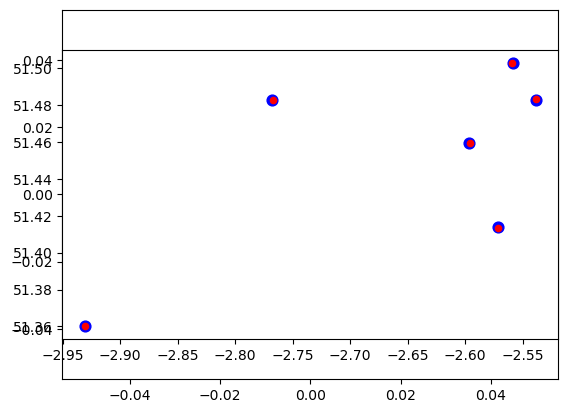

In [12]:
plt.figure()
fig = plt.plot(); ax = plt.axes()
nodes[nodes.index.isin(nodelist)].plot(ax=ax, markersize = 60, color="b" )
pois.plot(ax=ax, markersize = 20, color="r")
plt.show();

### 4.3 Compute shortest path between each origin-destination pair of nodes
[`networkx.shortest_path_length(G, source=None, target=None, weight=None, method='dijkstra')`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length) - Compute shortest path lengths in the graph.   
Returns an int or a dictionary of int, depending on what is specified in the source and target parameters.

In [13]:
# define a function that calculates shortest path between the nodes on graph
def path_length(row):
    return nx.shortest_path_length(avon, row['node_o'], row['node_d'], weight='length')

# apply the function to our Origin and Destination nodes
%timeit flows_full['path_length'] = flows_full.apply(path_length, axis=1)

30.7 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# Total run time for the function to compute the shortest path lengths for all the node combinations
print("Total run time to compute shortest path lengths:", str(round((30.7*(7*1))/60,2)) + ' minutes')
flows_full.head()

Total run time to compute shortest path lengths: 3.58 minutes


,origin,destination,ID_code_o,X_o,Y_o,node_o,ID_code_d,X_d,Y_d,node_d,path_length,distances
0,A91120,A91120,A91120,-2.559063,51.50283,2914306154,A91120,-2.559063,51.502830,2914306154,0.000,0.000
1,A91120,A99931,A91120,-2.559063,51.50283,2914306154,A99931,-2.596140,51.459182,1572010429,6983.971,6973.997
2,A91120,A99986,A91120,-2.559063,51.50283,2914306154,A99986,-2.538833,51.483143,2094196650,4332.733,4332.730
3,A91120,L81002,A91120,-2.559063,51.50283,2914306154,L81002,-2.930352,51.360207,317399984,35962.683,35962.668
4,A91120,L81004,A91120,-2.559063,51.50283,2914306154,L81004,-2.767317,51.482805,298172819,20583.555,20545.777


## 5. Use Pandana to calculate walking distances
### 5.1 Load Graph
Listen, I have tried to use the osm loader inside the ``pandana``, but it took ages. after 2 hours of loading, I decided it will be easier to get the previously loaded osm graph with ``osmnx`` and use that as a base for the pandana graph. You can just simply use the geodataframes of nodes and flows for the base of your graph.

In [15]:
# reset index so our origins and destinations are not in idexes
edges = edges.reset_index()

# create network with pandana
avon_pan = pandana.Network(nodes['x'], nodes['y'], 
                          edges['u'], edges['v'], edges[['length']])

Find the nearest nodes to our points in pandana graph using `pandana.get_node_ids(x_col, y_col, mapping_distance=None)`   
Def: Assign node_ids to data specified by x_col and y_col.   
Returns a Pandas Series of node_ids for each x, y in the input data. 

In [16]:
# we are going to define the origins and destinations separately as a list
# get_node_ids uses kdtree writen in c++, google it its like a magic

origin_nodes = avon_pan.get_node_ids(flows_full.X_o, flows_full.Y_o).values
dests_nodes = avon_pan.get_node_ids(flows_full.X_d, flows_full.Y_d).values

origin_nodes

array([2914306154, 2914306154, 2914306154, 2914306154, 2914306154,
       2914306154, 1859320333, 1859320333, 1859320333, 1859320333,
       1859320333, 1859320333, 2094196650, 2094196650, 2094196650,
       2094196650, 2094196650, 2094196650,  317399984,  317399984,
        317399984,  317399984,  317399984,  317399984, 9429727608,
       9429727608, 9429727608, 9429727608, 9429727608, 9429727608,
       2424544775, 2424544775, 2424544775, 2424544775, 2424544775,
       2424544775], dtype=int64)

### 5.2 Compute shortest path between each origin-destination pair
[``pandana.shortest_path_lengths(nodes_a, nodes_b, imp_name=None)``](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_lengths) - Return array of float-values of the length of the shortest path between node IDs in the network. (Vectorized version).

In [17]:
%%time
flows_full['distances'] = pd.Series(avon_pan.shortest_path_lengths(origin_nodes, dests_nodes))

CPU times: total: 46.9 ms
Wall time: 90 ms


### 5.3 Compare time to compute shortest paths between NetworkX and Pandana

In [23]:
Networkx_time = 3.58 # minutes
Pandana_time = 90 # ms
speed_up = (Networkx_time*60)*1000/Pandana_time

print("This means Pandana was", round(speed_up,2), "times faster than Networkx for computing shortest paths for all the node combinations.")

This means Pandana was 2386.67 times faster than Networkx for computing shortest paths for all the node combinations.


### 5.4 Check that the nodes are the same as those from NetworkX
The distances seems to be satisfying but are we sure that the packages picked up the same nodes?

In [19]:
flows_full.head()

,origin,destination,ID_code_o,X_o,Y_o,node_o,ID_code_d,X_d,Y_d,node_d,path_length,distances
0,A91120,A91120,A91120,-2.559063,51.50283,2914306154,A91120,-2.559063,51.502830,2914306154,0.000,0.000
1,A91120,A99931,A91120,-2.559063,51.50283,2914306154,A99931,-2.596140,51.459182,1572010429,6983.971,6973.997
2,A91120,A99986,A91120,-2.559063,51.50283,2914306154,A99986,-2.538833,51.483143,2094196650,4332.733,4332.730
3,A91120,L81002,A91120,-2.559063,51.50283,2914306154,L81002,-2.930352,51.360207,317399984,35962.683,35962.668
4,A91120,L81004,A91120,-2.559063,51.50283,2914306154,L81004,-2.767317,51.482805,298172819,20583.555,20545.777


In [20]:
x = origin_nodes == flows_full['node_o']
x.describe()

count       36
unique       2
top       True
freq        18
Name: node_o, dtype: object

In [21]:
y = dests_nodes == flows_full['node_d']
y.describe()

count       36
unique       2
top       True
freq        18
Name: node_d, dtype: object

This looks spot on.

## Appendix for environment setup
If you want to run this on Google Colab, you need to install
1. Geopandas
2. OsmnX
3. Matplotlib

In [ ]:
# install Geopandas
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express# install packages

In [ ]:
# osmnx
# this gives errors but works ...no idea
!apt-get -qq install -y libspatialindex-dev && pip install -q -U osmnx 
ox.config(use_cache=True, log_console=True)

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3# mount the drive

In [ ]:
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - _r-mutex=1.0.1=anacondar_1
  - anyio=2.2.0=py39hcbf5309_0
  - argon2-cffi=20.1.0=py39hb82d6ee_2
  - async_generator=1.10=py_0
  - attrs=20.3.0=pyhd3deb0d_0
  - babel=2.9.0=pyhd3deb0d_0
  - backcall=0.2.0=pyh9f0ad1d_0
  - backports=1.0=py_2
  - backports.functools_lru_cache=1.6.1=py_0
  - bleach=3.3.0=pyh44b312d_0
  - blosc=1.21.0=h0e60522_0
  - boost-cpp=1.74.0=h54f0996_2
  - branca=0.4.2=pyhd8ed1ab_0
  - brotlipy=0.7.0=py39hb82d6ee_1001
  - bzip2=1.0.8=h8ffe710_4
  - ca-certificates=2020.12.5=h5b45459_0
  - cairo=1.16.0=hba8bd2f_1007
  - certifi=2020.12.5=py39hcbf5309_1
  - cffi=1.14.5=py39h0878f49_0
  - cfitsio=3.470=h0af3d06_7
  - chardet=4.0.0=py39hcbf5309_1
  - click=7.1.2=pyh9f0ad1d_0
  - click-plugins=1.1.1=py_0
  - cligj=0.7.1=pyhd8ed1ab_0
  - colorama=0.4.4=pyh9f0ad1d_0
  - cryptography=3.4.6=py39hd8d06c1_0
  - curl=7.75.0=hf1763fc_0
  - cycler=0.10.0=py_2
  - decorator=4.4.2=py_0
  - defusedxml=0.7.1=pyhd8ed1ab_0
  - descartes=1.1.0=py_4
  - entrypoints=0.3=pyhd8ed1ab_1003
  - expat=2.2.10=h39d44d4_0
  - fiona=1.8.18=py39h9f1b043_1
  - folium=0.12.0=pyhd8ed1ab_0
  - fontconfig=2.13.1=h1989441_1004
  - freetype=2.10.4=h546665d_1
  - freexl=1.0.5=hd288d7e_1002
  - gdal=3.2.2=py39h6795fcd_0
  - geopandas=0.9.0=pyhd8ed1ab_0
  - geos=3.9.1=h39d44d4_2
  - geotiff=1.6.0=h8e90983_5
  - gettext=0.19.8.1=h1a89ca6_1005
  - hdf4=4.2.13=h0e5069d_1004
  - hdf5=1.10.6=nompi_h5268f04_1114
  - icu=68.1=h0e60522_0
  - idna=2.10=pyh9f0ad1d_0
  - importlib-metadata=3.7.2=py39hcbf5309_0
  - intel-openmp=2020.3=h57928b3_311
  - ipykernel=5.5.0=py39h832f523_1
  - ipython=7.21.0=py39h832f523_0
  - ipython_genutils=0.2.0=py_1
  - jedi=0.18.0=py39hcbf5309_2
  - jinja2=2.11.3=pyh44b312d_0
  - joblib=1.0.1=pyhd8ed1ab_0
  - jpeg=9d=h8ffe710_0
  - json5=0.9.5=pyh9f0ad1d_0
  - jsonschema=3.2.0=pyhd8ed1ab_3
  - jupyter-packaging=0.7.12=pyhd8ed1ab_0
  - jupyter_client=6.1.11=pyhd8ed1ab_1
  - jupyter_core=4.7.1=py39hcbf5309_0
  - jupyter_server=1.4.1=py39hcbf5309_0
  - jupyterlab=3.0.10=pyhd8ed1ab_0
  - jupyterlab_pygments=0.1.2=pyh9f0ad1d_0
  - jupyterlab_server=2.3.0=pyhd8ed1ab_0
  - kealib=1.4.14=h96bfa42_2
  - kiwisolver=1.3.1=py39h2e07f2f_1
  - krb5=1.17.2=hbae68bd_0
  - lcms2=2.12=h2a16943_0
  - libblas=3.9.0=8_mkl
  - libcblas=3.9.0=8_mkl
  - libcurl=7.75.0=hf1763fc_0
  - libffi=3.3=h0e60522_2
  - libgdal=3.2.2=hbe61683_0
  - libglib=2.66.7=h1e62bf3_1
  - libiconv=1.16=he774522_0
  - libkml=1.3.0=h02ac0ef_1012
  - liblapack=3.9.0=8_mkl
  - libnetcdf=4.7.4=nompi_h3a9aa94_107
  - libpng=1.6.37=h1d00b33_2
  - libpq=13.1=h4f54205_2
  - librttopo=1.1.0=hb340de5_6
  - libsodium=1.0.18=h8d14728_1
  - libspatialindex=1.9.3=h39d44d4_3
  - libspatialite=5.0.1=h6b539a6_4
  - libssh2=1.9.0=h680486a_6
  - libtiff=4.2.0=hc10be44_0
  - libwebp-base=1.2.0=h8ffe710_0
  - libxml2=2.9.10=hf5bbc77_3
  - lz4-c=1.9.3=h8ffe710_0
  - m2w64-bwidget=1.9.10=2
  - m2w64-bzip2=1.0.6=6
  - m2w64-expat=2.1.1=2
  - m2w64-fftw=3.3.4=6
  - m2w64-flac=1.3.1=3
  - m2w64-gcc-libgfortran=5.3.0=6
  - m2w64-gcc-libs=5.3.0=7
  - m2w64-gcc-libs-core=5.3.0=7
  - m2w64-gettext=0.19.7=2
  - m2w64-gmp=6.1.0=2
  - m2w64-gsl=2.1=2
  - m2w64-libiconv=1.14=6
  - m2w64-libjpeg-turbo=1.4.2=3
  - m2w64-libogg=1.3.2=3
  - m2w64-libpng=1.6.21=2
  - m2w64-libsndfile=1.0.26=2
  - m2w64-libtiff=4.0.6=2
  - m2w64-libvorbis=1.3.5=2
  - m2w64-libwinpthread-git=5.0.0.4634.697f757=2
  - m2w64-libxml2=2.9.3=3
  - m2w64-mpfr=3.1.4=4
  - m2w64-pcre2=10.34=0
  - m2w64-speex=1.2rc2=3
  - m2w64-speexdsp=1.2rc3=3
  - m2w64-tcl=8.6.5=3
  - m2w64-tk=8.6.5=3
  - m2w64-tktable=2.10=5
  - m2w64-wineditline=2.101=5
  - m2w64-xz=5.2.2=2
  - m2w64-zlib=1.2.8=10
  - markupsafe=1.1.1=py39hb82d6ee_3
  - matplotlib-base=3.3.4=py39h581301d_0
  - mistune=0.8.4=py39hb82d6ee_1003
  - mkl=2020.4=hb70f87d_311
  - mock=4.0.3=py39hcbf5309_1
  - msys2-conda-epoch=20160418=1
  - munch=2.5.0=py_0
  - nbclassic=0.2.6=pyhd8ed1ab_0
  - nbclient=0.5.3=pyhd8ed1ab_0
  - nbconvert=6.0.7=py39hcbf5309_3
  - nbformat=5.1.2=pyhd8ed1ab_1
  - nest-asyncio=1.4.3=pyhd8ed1ab_0
  - networkx=2.5=py_0
  - notebook=6.2.0=py39hcbf5309_0
  - numexpr=2.7.3=py39h2e25243_0
  - numpy=1.20.1=py39h6635163_0
  - olefile=0.46=pyh9f0ad1d_1
  - openjpeg=2.4.0=h48faf41_0
  - openssl=1.1.1j=h8ffe710_0
  - osmnx=1.0.1=pyhd3deb0d_0
  - packaging=20.9=pyh44b312d_0
  - pandana=0.6=py39h2e25243_0
  - pandas=1.2.3=py39h2e25243_0
  - pandoc=2.12=h8ffe710_0
  - pandocfilters=1.4.2=py_1
  - parso=0.8.1=pyhd8ed1ab_0
  - pcre=8.44=ha925a31_0
  - pickleshare=0.7.5=py_1003
  - pillow=8.1.2=py39h1a9d4f7_0
  - pip=21.0.1=pyhd8ed1ab_0
  - pixman=0.40.0=h8ffe710_0
  - poppler=21.03.0=h9ff6ed8_0
  - poppler-data=0.4.10=0
  - postgresql=13.1=h0f1a9bc_2
  - proj=8.0.0=h1cfcee9_0
  - prometheus_client=0.9.0=pyhd3deb0d_0
  - prompt-toolkit=3.0.16=pyha770c72_0
  - pycparser=2.20=pyh9f0ad1d_2
  - pygments=2.8.1=pyhd8ed1ab_0
  - pyopenssl=20.0.1=pyhd8ed1ab_0
  - pyparsing=2.4.7=pyh9f0ad1d_0
  - pyproj=3.0.1=py39h1007a03_1
  - pyrsistent=0.17.3=py39hb82d6ee_2
  - pysocks=1.7.1=py39hcbf5309_3
  - pytables=3.6.1=py39h42e6cd8_3
  - python=3.9.2=h7840368_0_cpython
  - python-dateutil=2.8.1=py_0
  - python_abi=3.9=1_cp39
  - pytz=2021.1=pyhd8ed1ab_0
  - pywin32=300=py39hb82d6ee_0
  - pywinpty=0.5.7=py39hde42818_1
  - pyzmq=22.0.3=py39he46f08e_1
  - r-base=4.0.3=hddad469_7
  - r-iterators=1.0.13=r40h142f84f_0
  - r-itertools=0.1_3=r40_1003
  - requests=2.25.1=pyhd3deb0d_0
  - rtree=0.9.7=py39h09fdee3_1
  - scikit-learn=0.24.1=py39he931e04_0
  - scipy=1.6.0=py39hc0c34ad_0
  - send2trash=1.5.0=py_0
  - setuptools=49.6.0=py39hcbf5309_3
  - shapely=1.7.1=py39h90c6b7e_4
  - six=1.15.0=pyh9f0ad1d_0
  - sniffio=1.2.0=py39hcbf5309_1
  - sqlite=3.34.0=h8ffe710_0
  - terminado=0.9.2=py39hcbf5309_0
  - testpath=0.4.4=py_0
  - threadpoolctl=2.1.0=pyh5ca1d4c_0
  - tiledb=2.2.4=hddc2a84_2
  - tk=8.6.10=h8ffe710_1
  - tornado=6.1=py39hb82d6ee_1
  - traitlets=5.0.5=py_0
  - tzdata=2021a=he74cb21_0
  - urllib3=1.26.3=pyhd8ed1ab_0
  - vc=14.2=hb210afc_4
  - vs2015_runtime=14.28.29325=h5e1d092_4
  - wcwidth=0.2.5=pyh9f0ad1d_2
  - webencodings=0.5.1=py_1
  - wheel=0.36.2=pyhd3deb0d_0
  - win_inet_pton=1.1.0=py39hcbf5309_2
  - wincertstore=0.2=py39hcbf5309_1006
  - winpty=0.4.3=4
  - xerces-c=3.2.3=h0e60522_2
  - xz=5.2.5=h62dcd97_1
  - zeromq=4.3.4=h0e60522_0
  - zipp=3.4.1=pyhd8ed1ab_0
  - zlib=1.2.11=h62dcd97_1010
  - zstd=1.4.9=h6255e5f_0